# TSA with Facebook's Prophet

1. install fbprophet
2. wrangle data
3. split data
4. fit model
5. forecast using "make_future_dataframe"
6. forecast using cross validation
7. evaluate

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from math import sqrt

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.plot import plot_forecast_component

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
pd.plotting.register_matplotlib_converters()
import seaborn as sns

In [2]:
import fbprophet
fbprophet.__version__

'0.4'

Wrangle

- dataframe 
- columns = `ds` & `y`
- `ds` is datetime, `y` is numeric

In [3]:
df = pd.read_csv('store_item_demand.csv')

def prep_data(df):
    return df.\
            assign(ds=pd.to_datetime(df.sale_date)).\
            sort_values('ds').\
            assign(y=df.sale_amount * df.item_price).\
            groupby(['ds'])['y'].sum().\
            reset_index().\
            set_index('ds')

df = prep_data(df)

In [4]:
# number of rows
print(df.shape)

# First and last 2 rows
pd.concat([df.head(2), df.tail(2)])

(1826, 1)


,y
ds,
2013-01-01,73844.01
2013-01-02,73570.58
2017-12-30,134903.07
2017-12-31,140905.74


Split Data

In [5]:
train = df[:'2015']
validate = df['2016']
test = df['2017']

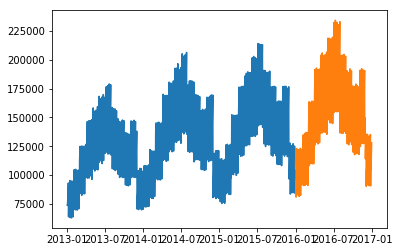

In [6]:
plt.plot(train)
plt.plot(validate)

In [7]:
print(test.shape)
pd.concat([test.head(2), test.tail(2)])

(365, 1)


,y
ds,
2017-01-01,127262.71
2017-01-02,85329.98
2017-12-30,134903.07
2017-12-31,140905.74


Set cap and floor for our data. 


In [8]:
train['cap'] = 250000
train['floor'] = 25000

In [9]:
train.head()

,y,cap,floor
ds,,,
2013-01-01,73844.01,250000,25000
2013-01-02,73570.58,250000,25000
2013-01-03,78169.48,250000,25000
2013-01-04,84467.73,250000,25000
2013-01-05,87621.85,250000,25000


In [10]:
train = train.reset_index()
validate = validate.reset_index()
test = test.reset_index()

Build our first model

In [11]:
help(Prophet)

Help on class Prophet in module fbprophet.forecaster:

class Prophet(builtins.object)
 |  Prophet forecaster.
 |  
 |  Parameters
 |  ----------
 |  growth: String 'linear' or 'logistic' to specify a linear or logistic
 |      trend.
 |  changepoints: List of dates at which to include potential changepoints. If
 |      not specified, potential changepoints are selected automatically.
 |  n_changepoints: Number of potential changepoints to include. Not used
 |      if input `changepoints` is supplied. If `changepoints` is not supplied,
 |      then n_changepoints potential changepoints are selected uniformly from
 |      the first `changepoint_range` proportion of the history.
 |  changepoint_range: Proportion of history in which trend changepoints will
 |      be estimated. Defaults to 0.8 for the first 80%. Not used if
 |      `changepoints` is specified.
 |  Not used if input `changepoints` is supplied.
 |  yearly_seasonality: Fit yearly seasonality.
 |      Can be 'auto', True, Fals

In [12]:
m = Prophet(growth = 'logistic', 
            weekly_seasonality = True, 
            daily_seasonality = False,
            changepoint_range = 0.8)
m.add_country_holidays(country_name='US')
m.fit(train)

In [13]:
m.train_holiday_names

0                  New Year's Day
1     Martin Luther King, Jr. Day
2           Washington's Birthday
3                    Memorial Day
4                Independence Day
5                       Labor Day
6                    Columbus Day
7                    Veterans Day
8                    Thanksgiving
9                   Christmas Day
10    Independence Day (Observed)
dtype: object

## Predict

1. Predict using Future DataFrame
2. Using CV method

### Predict using future dataframe

periods = how many days beyond train do I want it to predict. 
In this case, I want it to predict the number of days that included in validate. 
make_future_dataframes() is going to create a dataframe who's dates will range from the min(train) to the max(validate). 

We also will need to add the 'cap' and 'floor' to this future dataframe. 

In [14]:
future = m.make_future_dataframe(periods = len(validate))
future['cap'] = 500000
future['floor'] = 0

In [15]:
print(future.head(1))
print(future.tail(1))

          ds     cap  floor
0 2013-01-01  500000      0
             ds     cap  floor
1460 2016-12-31  500000      0


In [16]:
forecast = m.predict(future)

In [17]:
# forecast.head()
forecast.columns

Index(['ds', 'trend', 'cap', 'floor', 'yhat_lower', 'yhat_upper',
       'trend_lower', 'trend_upper', 'Christmas Day', 'Christmas Day_lower',
       'Christmas Day_upper', 'Columbus Day', 'Columbus Day_lower',
       'Columbus Day_upper', 'Independence Day', 'Independence Day_lower',
       'Independence Day_upper', 'Independence Day (Observed)',
       'Independence Day (Observed)_lower',
       'Independence Day (Observed)_upper', 'Labor Day', 'Labor Day_lower',
       'Labor Day_upper', 'Martin Luther King, Jr. Day',
       'Martin Luther King, Jr. Day_lower',
       'Martin Luther King, Jr. Day_upper', 'Memorial Day',
       'Memorial Day_lower', 'Memorial Day_upper', 'New Year's Day',
       'New Year's Day_lower', 'New Year's Day_upper', 'Thanksgiving',
       'Thanksgiving_lower', 'Thanksgiving_upper', 'Veterans Day',
       'Veterans Day_lower', 'Veterans Day_upper', 'Washington's Birthday',
       'Washington's Birthday_lower', 'Washington's Birthday_upper',
       'additive_

Add actual values to 'forecast' dataframe. 
These come from both train and validate. 

In [18]:
forecast = pd.concat([forecast, df[:'2016'].reset_index().y], axis = 1)

In [19]:
# forecast.columns

In [20]:
forecast[(forecast['Christmas Day'] + 
          forecast['Thanksgiving'] + 
          forecast["New Year's Day"]).\
         abs() > 0
        ][['ds', 'y', 'yhat', 
           'Christmas Day', 
           'Thanksgiving', 
           "New Year's Day"]][-10:]

,ds,y,yhat,Christmas Day,Thanksgiving,New Year's Day
358,2013-12-25,82576.48,176821.731349,1528.132118,0.000000,0.000000
365,2014-01-01,83630.73,178729.419163,0.000000,0.000000,1758.594479
695,2014-11-27,140309.12,250631.978047,0.000000,13819.376734,0.000000
723,2014-12-25,99840.03,212051.756649,1528.132118,0.000000,0.000000
730,2015-01-01,92586.37,213327.804140,0.000000,0.000000,1758.594479
1059,2015-11-26,148941.86,268978.293665,0.000000,13819.376734,0.000000
1088,2015-12-25,112176.34,236716.798360,1528.132118,0.000000,0.000000
1095,2016-01-01,107875.26,238130.351006,0.000000,0.000000,1758.594479
1423,2016-11-24,159026.05,287939.889814,0.000000,13819.376734,0.000000
1454,2016-12-25,135125.06,270838.007717,1528.132118,0.000000,0.000000


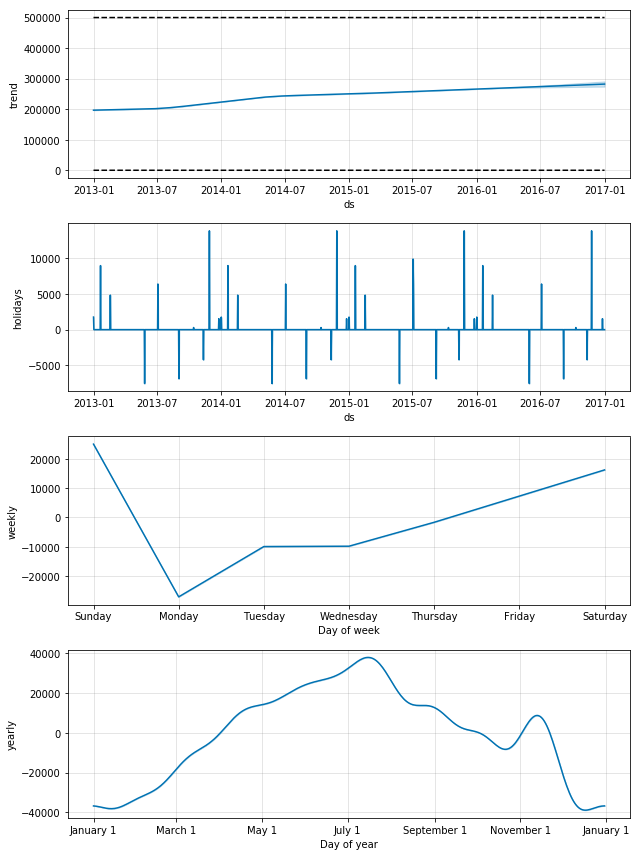

In [21]:
fig2 = m.plot_components(forecast, 'holidays')

Plot predictions

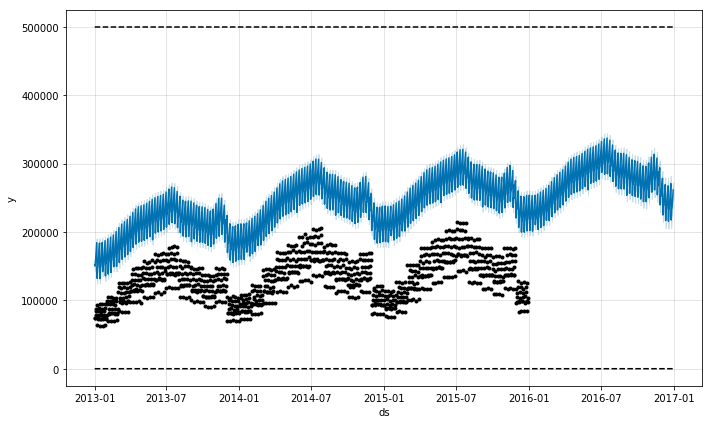

In [22]:
fig1 = m.plot(forecast)

In [23]:
from sklearn.metrics import mean_squared_error
sqrt(mean_squared_error(forecast.y, forecast.yhat))

109546.06662587197

In [24]:
# need this cutoff to run performance metrics. This is the end of the data used for the first predictions. 
forecast['cutoff'] = train.ds.iloc[-1]

In [25]:
# need y to run performance metrics
y = pd.DataFrame(df[:'2016']['y'])
forecast['y'] = y.reset_index()

In [26]:
forecast.head()

,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y,cutoff
0,2013-01-01,196712.663917,500000,0,144579.555364,158355.690935,196712.663917,196712.663917,0.0,0.0,...,-9914.896212,-36814.182006,-36814.182006,-36814.182006,0.0,0.0,0.0,151742.180179,2013-01-01 00:00:00,2015-12-31
1,2013-01-02,196738.835068,500000,0,143007.724919,156943.030434,196738.835068,196738.835068,0.0,0.0,...,-9797.867057,-36872.971026,-36872.971026,-36872.971026,0.0,0.0,0.0,150067.996986,2013-01-02 00:00:00,2015-12-31
2,2013-01-03,196765.007442,500000,0,151051.816101,164855.054715,196765.007442,196765.007442,0.0,0.0,...,-1649.829272,-36964.128022,-36964.128022,-36964.128022,0.0,0.0,0.0,158151.050148,2013-01-03 00:00:00,2015-12-31
3,2013-01-04,196791.181038,500000,0,160095.781180,174438.415803,196791.181038,196791.181038,0.0,0.0,...,7269.429469,-37082.011548,-37082.011548,-37082.011548,0.0,0.0,0.0,166978.598959,2013-01-04 00:00:00,2015-12-31
4,2013-01-05,196817.355856,500000,0,168409.214037,182874.306681,196817.355856,196817.355856,0.0,0.0,...,16185.673088,-37220.094464,-37220.094464,-37220.094464,0.0,0.0,0.0,175782.934481,2013-01-05 00:00:00,2015-12-31


Take a look at the forecast dataframe. 

In [27]:
forecast['cutoff'] = '2015-12-31'

In [28]:
forecast.cutoff.value_counts()

2015-12-31    1461
Name: cutoff, dtype: int64

Evaluate

In [29]:
# in progress
# forecast_p = performance_metrics(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'y', 'cutoff']])
# forecast_p

Predict using Cross Validation

In [30]:
# format for initial, period and horizon should be in format 
# used by pandas timedelta, which accepts units of days or shorter. 

df_cv = cross_validation(m, 
                         initial = '730 days', 
                         period = '90 days', 
                         horizon = '180 days', 
                        )
df_cv.head()


INFO:fbprophet:Making 3 forecasts with cutoffs between 2015-01-05 00:00:00 and 2015-07-04 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-01-06,94469.053278,87863.740263,101309.550874,88606.83,2015-01-05
1,2015-01-07,94466.034513,87926.014142,101045.930372,87704.19,2015-01-05
2,2015-01-08,102342.468025,95747.719616,108552.147415,94971.00,2015-01-05
3,2015-01-09,110962.446540,103977.188262,117564.611932,101312.99,2015-01-05
4,2015-01-10,120076.966911,113226.334580,126757.958376,106900.92,2015-01-05


In [31]:
df_cv.cutoff.value_counts()

2015-07-04    180
2015-04-05    180
2015-01-05    180
Name: cutoff, dtype: int64

In [32]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,coverage
17,18 days,6.658519e+07,8159.974815,6865.020268,0.055069,0.537037
198,19 days,6.599267e+07,8123.587564,6784.968886,0.054027,0.537037
18,19 days,7.087482e+07,8418.718581,7006.461009,0.056196,0.518519
378,19 days,6.598117e+07,8122.879129,6788.249197,0.055269,0.537037
19,20 days,7.116616e+07,8436.003943,6997.242886,0.056787,0.537037


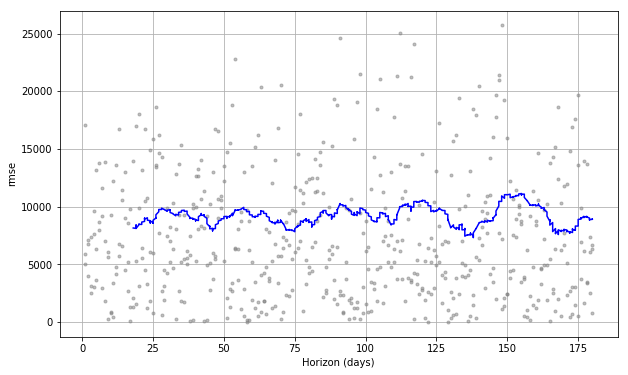

In [34]:
fig = plot_cross_validation_metric(df_cv, metric = 'rmse', rolling_window = .1)

The blue line represents the metric. 
In the case of MAPE, the mean is taken over a rolling window of the dots. Here, we are erroring around 5% pretty consistently across the horizon. We can change the size of the rollling window with the arguement rolling_window, which specifies the proportion of forecasts to use in each rolling window. The default is .1, or 10% of the rows from df_cv. A larger rolling window will create a smoother curve. 

In [ ]:
df_cv.head()